In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import backtrader as bt
import matplotlib.pyplot as plt
import tushare as ts
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from backtrader.feeds import PandasData
import backtrader.indicators as btind
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
import multiprocessing
from pyswarm import pso
from xgboost import XGBRegressor
from backtrader.analyzers import SharpeRatio, DrawDown, TradeAnalyzer
plt.rcParams["font.sans-serif"]=["SimHei"]  # 设置画图时的中文显示
plt.rcParams["axes.unicode_minus"]=False  # 设置画图时的负号显示

def get_data(code='600519',starttime='2016-01-01',endtime='2020-12-31'):
    df=ts.get_k_data(code,start=starttime,end=endtime)
    df.index=pd.to_datetime(df.date)
    df['openinterest']=0
    df=df[['open','high','low','close','volume','openinterest']]  # 整合数据至满足backtrader框架
    return df
stock_df=get_data()
fromdate=datetime(2016,1,1)
todate=datetime(2020,12,31)
data=bt.feeds.PandasData(dataname=stock_df,fromdate=fromdate,todate=todate)  # 加载数据
import warnings
warnings.filterwarnings("ignore")

本接口即将停止更新，请尽快使用Pro版接口：https://tushare.pro/document/2


In [2]:
# 构建策略
accuracies = [] #记录正确率
total_money = [] #记录资金
class MyStrategy(bt.Strategy):
    params = (
        ('lookback_period', 300),
        ('split_index', 225),
        ('s_time', 4),
        ('m_time', 6),
        ('l_time', 15),
    )
    
    def __init__(self):
        self.order=None
        self.start_cash = 10000000
        self.stop_loss = 0.05  # 设置止损
        self.take_profit = 0.10  # 设置止盈
        self.data_close = self.datas[0].close
        self.model = SVC(kernel='linear')  # 使用线性核的支持向量机模型
        self.cci = btind.CommodityChannelIndex(self.data, period=20)
        self.macd = btind.MACD(self.data, period_me1=12, period_me2=26, period_signal=9)
        self.ma4 = bt.indicators.SimpleMovingAverage(self.data, period=self.params.s_time)
        self.ma6 = bt.indicators.SimpleMovingAverage(self.data, period=self.params.m_time)
        self.ma15 = bt.indicators.SimpleMovingAverage(self.data, period=self.params.l_time)
        self.ma20 = bt.indicators.SimpleMovingAverage(self.data, period=20)
        self.ma40 = bt.indicators.SimpleMovingAverage(self.data, period=40)
        self.atr = bt.indicators.AverageTrueRange(self.data, period=14)
        self.trade_analyzer = bt.analyzers.TradeAnalyzer()
        self.entry_price = 0
        self.price_record = []
        
        
    def next(self):
        # 如果历史数据不足以进行预测，则不执行任何操作
        if len(self.data) < self.params.lookback_period:
            return
        # 获取历史数据
        hist_open = self.data.open.get(size=400)
        hist_high = self.data.high.get(size=400)
        hist_low = self.data.low.get(size=400)
        hist_close = self.data.close.get(size=400)
        hist_volume = self.data.volume.get(size=400)
        hist_cci = self.cci.get(size=400)
        hist_macd = self.macd.get(size=400)
        hist_atr = self.atr.get(size=400)
        hist_ma4 = self.ma4.get(size=400)
        hist_ma6 = self.ma6.get(size=400)
        hist_ma15 = self.ma15.get(size=400)
        hist_ma20 = self.ma20.get(size=400)
        hist_ma40 = self.ma40.get(size=400)
        
        hist_data_df = pd.DataFrame(data=zip(hist_open,hist_high,hist_low,hist_close,hist_volume,hist_atr,hist_cci,hist_macd,hist_ma4,hist_ma6,hist_ma15,hist_ma20,hist_ma40),
                                    columns=['open','high','low','close','volume','atr','cci','macd','ma4','ma6','ma15','ma20','ma40'])

        #print(hist_data_df)  # 得到历史n日的交易数据
        if hist_data_df.isna().any().any() or hist_data_df.empty:
            return
        st_data_df = data_deal(hist_data_df)

        #print(st_data_df)
        try:
            signal = svm_predict_Stacking(st_data_df)
        except:
            print(f"模型训练失败，时间：{self.datas[0].datetime.datetime(0)}")
            signal=0
        #signal=1
        if self.order:  # 如果有挂单，则不执行后续操作
            if self.order.status in [bt.Order.Submitted, bt.Order.Accepted]:
                print("等待订单成交")
                return  # 等待订单成交
            elif self.order.status in [bt.Order.Partial, bt.Order.Completed]:
                print("清空订单状态")
                self.order = None  # 清空订单状态
            elif self.order.status in [bt.Order.Canceled, bt.Order.Rejected]:
                print("取消订单并重新发出")
                self.order = None  # 取消订单并重新发出
                return
            else:
                print("交易失败")
        # 根据预测结果生成买卖信号
        count = 0
        if len(self.price_record) > 0:
            for i in range(len(self.price_record)):
                self.price_record[i][2] += 1
            if self.price_record[0][2] == 7:
                count-=self.price_record[0][1]  # 持有7日者平仓
                self.price_record.pop(0) #踢出第7日前的数据，表示平仓
                print(f"持有达期限，平仓，时间：{self.datas[0].datetime.datetime(0)}")
        if len(self.price_record) > 0:
            j=[]
            for i in range(len(self.price_record)):
                if self.price_record[i][1] == 1 and self.data_close[0]/self.price_record[i][0] > 1.02: #如果持多仓且涨幅超过2%
                    count -= 1 #卖多平仓
                    print(f"卖多平仓，位置{i}")
                    j.append(i)
                if self.price_record[i][1] == -1 and self.data.close[0]/self.price_record[i][0] < 0.98: #如果持空仓且跌幅超过2%
                    count += 1 #买空平仓
                    print(f"买空平仓，位置{i}")
                    j.append(i)
            if len(j) != 0:
                self.price_record=[self.price_record[idx] for idx in range(len(self.price_record)) if idx not in j]

        if signal == 1:
            if self.data_close[0] < self.data_close[-1]:  # 如果市场行情低于当日收盘价
                count += 1 #买多开仓
                self.price_record.append([self.data_close[0],signal,0])
            else:
                print(f"无交易时机，时间：{self.datas[0].datetime.datetime(0)}")
        if signal == -1:
            if self.data_close[0] > self.data_close[-1]:  # 如果市场行情高于当日收盘价
                count -= 1 #卖空开仓
                self.price_record.append([self.data_close[0],signal,0])
            else:
                print(f"无交易时机，时间：{self.datas[0].datetime.datetime(0)}")  
        if count > 0:
            size=2000*count
            self.order = self.buy(size=size)
            self.entry_price = self.data.close[0]  # 记录开仓价格
            print(f"当日执行买入，时间：{self.datas[0].datetime.datetime(0)}")
        elif count < 0:
            size=2000*count
            self.order = self.sell(size=size)
            self.entry_price = self.data.close[0]  # 记录开仓价格
            print(f"当日执行卖出，时间：{self.datas[0].datetime.datetime(0)}")
        else:
            print(f"当日未交易，时间：{self.datas[0].datetime.datetime(0)}")
        if len(self.price_record) > 0:
            print(f"当前持仓状态：{self.price_record}")
        print('当前可用资金{}，当前持仓量{}，当前持仓成本{}，开仓价格{}，当前价格{}'.format(self.broker.getcash(),
                                                                self.broker.getposition(self.data).size,
                                                                self.broker.getposition(self.data).price,
                                                                self.entry_price,self.data.close[0]))
        total_money.append(self.broker.getcash())
        
        
    def notify_order(self, order):
        if order.status in [order.Completed, order.Canceled, order.Margin]:
            self.order = None     

        
        
        
def data_deal(data):
    sign=[]
    X1=[]
    X2=[]
    X3=[]
    X4=[]
    X5=[]
    X6=[]
    X7=[]
    X8=[]
    X9=[]
    for i in range(len(data)):
        if i == 0:
            X1.append(1)
            X2.append(1)
            X3.append(1)
            X4.append(1)
            X5.append(1)
            X6.append(1)
            X7.append(1)
            X8.append(1)
            X9.append(1)
        else:
            X1.append(data['open'][i-1]/data['close'][i]-1)
            X2.append(data['close'][i-1]/data['close'][i]-1)
            X3.append(data['high'][i-1]/data['close'][i]-1)
            X4.append(data['low'][i-1]/data['close'][i]-1)
            X5.append(data['volume'][i]/data['volume'][i-1]-1)
            X6.append(data['atr'][i]/data['atr'][i-1]-1)
            X7.append(data['open'][i]/data['close'][i]-1)
            X8.append(data['high'][i]/data['close'][i]-1)
            X9.append(data['low'][i]/data['close'][i]-1)
            
        #收盘均线比较
        if data['ma4'][i] > data['ma40'][i]*1.005:
            sign.append(1)
        elif data['ma4'][i] < data['ma40'][i]*0.995:
            sign.append(-1)
        else:
            sign.append(0)

    d=pd.DataFrame(data=zip(X1,X2,X3,X4,X5,X6,X7,X8,X9,data['cci'],data['macd'],data['ma6'],sign),
                   columns=['X1','X2','X3','X4','X5','X6','X7','X8','X9','cci','macd','ma','sign'])
    return d
    

def svm_predict_Stacking(data):
    X_train = data.iloc[:-100, :-1]
    y_train = data['sign'][:-100]
    X_test = data.iloc[-100:, :-1]
    y_test = data['sign'][-100:]
    # 定义基础模型
    svm = SVC()
    mlp = MLPClassifier()
    rf = RandomForestClassifier()
    xgb = XGBRegressor()
    # 定义mlp目标函数
    def objective(params):
        clf = MLPClassifier(**params)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        return {'loss': -accuracy, 'status': STATUS_OK}
    # 定义参数网格
    param_grid_svm = {'C': np.linspace(0.1,10,num=10),
                      'gamma': np.linspace(0.1,10,num=10),
                      'kernel': ['rbf']}

    param_grid_mlp = {'hidden_layer_sizes': hp.choice('hidden_layer_sizes', [(50,), (100,), (150,)]),
                      'alpha': hp.loguniform('alpha', -6, 0),
                      'learning_rate_init': hp.loguniform('learning_rate_init', -4, 0),
                      'max_iter': hp.choice('max_iter', [100, 200, 300])}

    param_grid_rf = {'n_estimators': [50, 100, 150],
                     'max_depth': [None, 10, 20],
                     'min_samples_split': [2, 5, 10]}
    
    param_grid_xgb = {'n_estimators': [100, 200, 300],
                      'max_depth': [3, 5, 7],
                      'learning_rate': [0.05, 0.1, 0.2],
                      'subsample': [0.6, 0.8, 1.0],
                      'colsample_bytree': [0.6, 0.8, 1.0],
                      'gamma': [0, 0.1, 0.2]}
    # 搜索优化
    # 网格搜索
    svm_grid_search = GridSearchCV(estimator=svm, param_grid=param_grid_svm, n_jobs=-1)
    svm_grid_search.fit(X_train, y_train)

    
    # 贝叶斯搜索
    trials = Trials()
    best = fmin(fn=objective,
                space=param_grid_mlp,
                algo=tpe.suggest,
                max_evals=50,
                trials=trials)
    best_params = {'hidden_layer_sizes': [(50,), (100,), (150,)][best['hidden_layer_sizes']],
               'alpha': best['alpha'],
               'learning_rate_init': best['learning_rate_init'],
               'max_iter': [100, 200, 300][best['max_iter']]}
    
    mlp_bayes_search = MLPClassifier(**best_params)
    mlp_bayes_search.fit(X_train, y_train)

    # 随机搜索
    rf_random_search = RandomizedSearchCV(rf, param_grid_rf, n_iter=10, n_jobs=-1)
    rf_random_search.fit(X_train, y_train)

    # 获取最优模型
    best_svm = svm_grid_search.best_estimator_
    best_mlp = mlp_bayes_search
    best_rf = rf_random_search.best_estimator_
    
    
    logistic_regression = LogisticRegression()
    
    base_models = [
        ('svm', best_svm),
        ('mlp', best_mlp),
        ('rf', best_rf),
    ]
    meta_model = LogisticRegression()
    
    stacking_model = StackingClassifier(estimators=base_models, final_estimator=meta_model)
    # 训练Stacking模型
    stacking_model.fit(X_train, y_train)
    # 预测测试集
    y_pred = stacking_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)
    print(f"Stacking模型的准确率为: {accuracy}")
    prediction = stacking_model.predict([data.iloc[-1, :-1]])
    print("预测结果是：{}，实际涨跌情况：{}".format(int(prediction),int(data.iloc[-2,-1])))
    return int(prediction)
    
    
    
    
# 策略设置 
cerebro=bt.Cerebro() # 创建引擎
# 将数据加入回测系统
cerebro.adddata(data)
# 加入自己的策略
cerebro.addstrategy(MyStrategy)

startcash=10000000
cerebro.broker.setcash(startcash)  # 经纪人
cerebro.broker.setcommission(0.0002)  # 设置手续费
s=fromdate.strftime("%Y-%m-%d")
t=todate.strftime("%Y-%m-%d")
# 添加分析器
cerebro.addanalyzer(SharpeRatio, _name='sharpe')
cerebro.addanalyzer(DrawDown, _name='drawdown')
cerebro.addanalyzer(TradeAnalyzer, _name='trade')
cerebro.addanalyzer(bt.analyzers.Returns, _name='returns')

print(f"初始资金：{startcash}\n回测时间：{s}-{t}")
result = cerebro.run()  # 执行回测
portval=cerebro.broker.getvalue()
print(f"剩余资金：{portval}\n回测时间：{s}-{t}")
if len(accuracies):
    overall_accuracy = sum(accuracies) / len(accuracies)
    print(f"\n平均正确率：{overall_accuracy}")
else:
    print("\n无正确率，回测失败")

# 获取分析器结果
sharpe_ratio = result[0].analyzers.sharpe.get_analysis()
max_drawdown = result[0].analyzers.drawdown.get_analysis()
trade_analyzer = result[0].analyzers.trade.get_analysis()
all_yield = result[0].analyzers.returns.get_analysis()
total_trades = trade_analyzer.total.total
profitable_trades = trade_analyzer.won.total
win_rate = profitable_trades / total_trades if total_trades > 0 else 0
# 打印结果
print("夏普比率:", sharpe_ratio)
print("最大回撤:", max_drawdown)
print("收益率: ",all_yield)
print("胜率:", win_rate)

初始资金：10000000
回测时间：2016-01-01-2020-12-31
100%|█████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 14.03trial/s, best loss: -0.92]
Stacking模型的准确率为: 0.91
预测结果是：1，实际涨跌情况：1
当日执行买入，时间：2017-10-23 00:00:00
当前持仓状态：[[422.952, 1, 0]]
当前可用资金10000000.0，当前持仓量0，当前持仓成本0.0，开仓价格422.952，当前价格422.952
100%|█████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 12.72trial/s, best loss: -0.92]
Stacking模型的准确率为: 0.89
预测结果是：1，实际涨跌情况：1
当日执行买入，时间：2017-10-24 00:00:00
当前持仓状态：[[422.952, 1, 1], [416.872, 1, 0]]
当前可用资金9156747.3832，当前持仓量2000，当前持仓成本421.542，开仓价格416.872，当前价格416.872
100%|█████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 13.96trial/s, best loss: -0.93]
Stacking模型的准确率为: 0.89
预测结果是：1，实际涨跌情况：1
当日执行买入，时间：2017-10-25 00:00:00
当前持仓状态：[[422.952, 1, 2], [416.872, 1, 1], [415.212, 1, 0]]
当前可用资金8317995.6663999995，当前持仓量4000，当前持仓成本420.417，开仓价格415.212，当前价格415.212
100%|█████████████████████████████████████████████████████████████| 

100%|█████████████████████████████████████████████████████████████| 50/50 [00:04<00:00, 11.46trial/s, best loss: -0.95]
Stacking模型的准确率为: 0.93
预测结果是：1，实际涨跌情况：1
卖多平仓，位置0
无交易时机，时间：2018-01-03 00:00:00
当日执行卖出，时间：2018-01-03 00:00:00
当前可用资金9588610.278399998，当前持仓量2000，当前持仓成本549.542，开仓价格565.402，当前价格565.402
100%|█████████████████████████████████████████████████████████████| 50/50 [00:04<00:00, 11.32trial/s, best loss: -0.95]
Stacking模型的准确率为: 0.9
预测结果是：1，实际涨跌情况：1
无交易时机，时间：2018-01-04 00:00:00
当日未交易，时间：2018-01-04 00:00:00
当前可用资金10730265.901599998，当前持仓量0，当前持仓成本0.0，开仓价格565.402，当前价格586.612
100%|█████████████████████████████████████████████████████████████| 50/50 [00:04<00:00, 11.36trial/s, best loss: -0.96]
Stacking模型的准确率为: 0.91
预测结果是：1，实际涨跌情况：1
无交易时机，时间：2018-01-05 00:00:00
当日未交易，时间：2018-01-05 00:00:00
当前可用资金10730265.901599998，当前持仓量0，当前持仓成本0.0，开仓价格565.402，当前价格587.902
100%|█████████████████████████████████████████████████████████████| 50/50 [00:06<00:00,  2.55trial/s, best loss: -0.94]
Stacking模型的准确率为:

当前持仓状态：[[576.422, -1, 5], [596.012, -1, 4], [597.272, 1, 1], [591.542, 1, 0]]
当前可用资金12141081.887199992，当前持仓量-2000，当前持仓成本593.447，开仓价格591.542，当前价格591.542
100%|█████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  5.29trial/s, best loss: -0.93]
Stacking模型的准确率为: 0.91
预测结果是：1，实际涨跌情况：1
买空平仓，位置1
当日执行买入，时间：2018-03-22 00:00:00
当前持仓状态：[[576.422, -1, 6], [597.272, 1, 2], [591.542, 1, 1], [575.622, 1, 0]]
当前可用资金10953760.470399993，当前持仓量0，当前持仓成本0.0，开仓价格575.622，当前价格575.622
100%|█████████████████████████████████████████████████████████████| 50/50 [00:06<00:00,  7.28trial/s, best loss: -0.92]
Stacking模型的准确率为: 0.9
预测结果是：-1，实际涨跌情况：1
持有达期限，平仓，时间：2018-03-23 00:00:00
无交易时机，时间：2018-03-23 00:00:00
当日执行买入，时间：2018-03-23 00:00:00
当前持仓状态：[[597.272, 1, 3], [591.542, 1, 2], [575.622, 1, 1]]
当前可用资金8751152.036799993，当前持仓量4000，当前持仓成本550.542，开仓价格560.602，当前价格560.602
100%|█████████████████████████████████████████████████████████████| 50/50 [00:06<00:00,  3.78trial/s, best loss: -0.92]
Stacki

当前可用资金11158110.799999991，当前持仓量0，当前持仓成本0.0，开仓价格631.512，当前价格637.592
100%|█████████████████████████████████████████████████████████████| 50/50 [00:07<00:00, 10.15trial/s, best loss: -0.91]
Stacking模型的准确率为: 0.6
预测结果是：1，实际涨跌情况：1
当日执行买入，时间：2018-06-06 00:00:00
当前持仓状态：[[635.292, 1, 0]]
当前可用资金11158110.799999991，当前持仓量0，当前持仓成本0.0，开仓价格635.292，当前价格635.292
100%|█████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  6.35trial/s, best loss: -0.92]
Stacking模型的准确率为: 0.52
预测结果是：1，实际涨跌情况：1
当日执行买入，时间：2018-06-07 00:00:00
当前持仓状态：[[635.292, 1, 1], [630.512, 1, 0]]
当前可用资金9878810.99119999，当前持仓量2000，当前持仓成本639.522，开仓价格630.512，当前价格630.512
100%|█████████████████████████████████████████████████████████████| 50/50 [00:06<00:00,  7.23trial/s, best loss: -0.93]
Stacking模型的准确率为: 0.56
预测结果是：1，实际涨跌情况：1
当日执行买入，时间：2018-06-08 00:00:00
当前持仓状态：[[635.292, 1, 2], [630.512, 1, 1], [627.492, 1, 0]]
当前可用资金8619475.17439999，当前持仓量4000，当前持仓成本634.532，开仓价格627.492，当前价格627.492
100%|█████████████████████████████

100%|█████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  6.03trial/s, best loss: -0.92]
Stacking模型的准确率为: 0.88
预测结果是：-1，实际涨跌情况：-1
当日执行卖出，时间：2018-08-14 00:00:00
当前持仓状态：[[546.821, -1, 5], [540.671, -1, 0]]
当前可用资金11914208.612799995，当前持仓量-2000，当前持仓成本552.421，开仓价格540.671，当前价格540.671
100%|█████████████████████████████████████████████████████████████| 50/50 [00:09<00:00, 10.72trial/s, best loss: -0.92]
Stacking模型的准确率为: 0.91
预测结果是：-1，实际涨跌情况：-1
买空平仓，位置0
买空平仓，位置1
无交易时机，时间：2018-08-15 00:00:00
当日执行买入，时间：2018-08-15 00:00:00
当前可用资金12994674.476399995，当前持仓量-4000，当前持仓成本546.381，开仓价格523.341，当前价格523.341
100%|█████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  8.95trial/s, best loss: -0.94]
Stacking模型的准确率为: 0.88
预测结果是：-1，实际涨跌情况：-1
无交易时机，时间：2018-08-16 00:00:00
当日未交易，时间：2018-08-16 00:00:00
当前可用资金10944100.443599995，当前持仓量0，当前持仓成本0.0，开仓价格523.341，当前价格508.981
100%|█████████████████████████████████████████████████████████████| 50/50 [00:11<00:00,  3.40t

当前可用资金10899064.279599993，当前持仓量0，当前持仓成本0.0，开仓价格502.281，当前价格384.541
100%|█████████████████████████████████████████████████████████████| 50/50 [00:05<00:00,  8.90trial/s, best loss: -0.92]
Stacking模型的准确率为: 0.89
预测结果是：-1，实际涨跌情况：-1
当日执行卖出，时间：2018-10-31 00:00:00
当前持仓状态：[[409.441, -1, 0]]
当前可用资金10899064.279599993，当前持仓量0，当前持仓成本0.0，开仓价格409.441，当前价格409.441
100%|█████████████████████████████████████████████████████████████| 50/50 [00:06<00:00,  8.12trial/s, best loss: -0.92]
Stacking模型的准确率为: 0.88
预测结果是：-1，实际涨跌情况：-1
当日执行卖出，时间：2018-11-01 00:00:00
当前持仓状态：[[409.441, -1, 1], [423.541, -1, 0]]
当前可用资金11729980.063199993，当前持仓量-2000，当前持仓成本415.541，开仓价格423.541，当前价格423.541
100%|██████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  7.05trial/s, best loss: -0.9]
Stacking模型的准确率为: 0.9
预测结果是：-1，实际涨跌情况：-1
当日执行卖出，时间：2018-11-02 00:00:00
当前持仓状态：[[409.441, -1, 2], [423.541, -1, 1], [460.441, -1, 0]]
当前可用资金12620883.846799994，当前持仓量-4000，当前持仓成本430.541，开仓价格460.441，当前价格460.441
100%|███████████

100%|█████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.84trial/s, best loss: -0.89]
Stacking模型的准确率为: 0.86
预测结果是：1，实际涨跌情况：1
持有达期限，平仓，时间：2019-01-09 00:00:00
卖多平仓，位置2
无交易时机，时间：2019-01-09 00:00:00
当日未交易，时间：2019-01-09 00:00:00
当前持仓状态：[[450.551, -1, 6], [459.521, -1, 5]]
当前可用资金12945250.722799996，当前持仓量-4000，当前持仓成本456.3485，开仓价格465.331，当前价格476.661
100%|█████████████████████████████████████████████████████████████| 50/50 [00:12<00:00,  5.54trial/s, best loss: -0.93]
Stacking模型的准确率为: 0.9
预测结果是：1，实际涨跌情况：1
持有达期限，平仓，时间：2019-01-10 00:00:00
无交易时机，时间：2019-01-10 00:00:00
当日执行买入，时间：2019-01-10 00:00:00
当前持仓状态：[[459.521, -1, 6]]
当前可用资金12945250.722799996，当前持仓量-4000，当前持仓成本456.3485，开仓价格479.311，当前价格479.311
100%|█████████████████████████████████████████████████████████████| 50/50 [00:06<00:00,  7.31trial/s, best loss: -0.92]
Stacking模型的准确率为: 0.86
预测结果是：1，实际涨跌情况：1
持有达期限，平仓，时间：2019-01-11 00:00:00
无交易时机，时间：2019-01-11 00:00:00
当日执行买入，时间：2019-01-11 00:00:00
当前可用资金11973974.50639999

当前可用资金9104834.533199998，当前持仓量4000，当前持仓成本645.346，开仓价格667.341，当前价格667.341
100%|█████████████████████████████████████████████████████████████| 50/50 [00:06<00:00,  5.86trial/s, best loss: -0.96]
Stacking模型的准确率为: 0.95
预测结果是：1，实际涨跌情况：1
无交易时机，时间：2019-03-29 00:00:00
当日未交易，时间：2019-03-29 00:00:00
当前可用资金11886442.100399997，当前持仓量0，当前持仓成本0.0，开仓价格667.341，当前价格714.531
100%|█████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  1.56trial/s, best loss: -0.96]
Stacking模型的准确率为: 0.97
预测结果是：1，实际涨跌情况：1
无交易时机，时间：2019-04-01 00:00:00
当日未交易，时间：2019-04-01 00:00:00
当前可用资金11886442.100399997，当前持仓量0，当前持仓成本0.0，开仓价格667.341，当前价格719.541
100%|█████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.78trial/s, best loss: -0.95]
Stacking模型的准确率为: 0.91
预测结果是：1，实际涨跌情况：1
当日执行买入，时间：2019-04-02 00:00:00
当前持仓状态：[[710.541, 1, 0]]
当前可用资金11886442.100399997，当前持仓量0，当前持仓成本0.0，开仓价格710.541，当前价格710.541
100%|█████████████████████████████████████████████████████████████| 50/50 [00:07<0

当前可用资金15717014.817999993，当前持仓量-4000，当前持仓成本766.761，开仓价格771.431，当前价格773.541
100%|█████████████████████████████████████████████████████████████| 50/50 [00:06<00:00,  4.39trial/s, best loss: -0.98]
Stacking模型的准确率为: 0.96
预测结果是：1，实际涨跌情况：0
当日执行买入，时间：2019-06-17 00:00:00
当前持仓状态：[[731.621, -1, 5], [771.431, -1, 4], [772.141, 1, 0]]
当前可用资金15717014.817999993，当前持仓量-4000，当前持仓成本766.761，开仓价格772.141，当前价格772.141
100%|█████████████████████████████████████████████████████████████| 50/50 [00:04<00:00, 10.82trial/s, best loss: -0.99]
Stacking模型的准确率为: 0.94
预测结果是：1，实际涨跌情况：0
无交易时机，时间：2019-06-18 00:00:00
当日未交易，时间：2019-06-18 00:00:00
当前持仓状态：[[731.621, -1, 6], [771.431, -1, 5], [772.141, 1, 1]]
当前可用资金14161621.801599992，当前持仓量-2000，当前持仓成本766.761，开仓价格772.141，当前价格777.541
100%|█████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  1.54trial/s, best loss: -0.97]
Stacking模型的准确率为: 0.97
预测结果是：1，实际涨跌情况：1
持有达期限，平仓，时间：2019-06-19 00:00:00
卖多平仓，位置1
无交易时机，时间：2019-06-19 00:00:00
当日未交易，时间：2019-06-19 0

无交易时机，时间：2019-08-23 00:00:00
当日未交易，时间：2019-08-23 00:00:00
当前可用资金12690666.824399998，当前持仓量0，当前持仓成本0.0，开仓价格979.08，当前价格1005.18
100%|█████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  7.35trial/s, best loss: -0.96]
Stacking模型的准确率为: 0.85
预测结果是：1，实际涨跌情况：1
当日执行买入，时间：2019-08-26 00:00:00
当前持仓状态：[[978.03, 1, 0]]
当前可用资金12690666.824399998，当前持仓量0，当前持仓成本0.0，开仓价格978.03，当前价格978.03
100%|█████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  5.42trial/s, best loss: -0.96]
Stacking模型的准确率为: 0.96
预测结果是：1，实际涨跌情况：1
无交易时机，时间：2019-08-27 00:00:00
当日未交易，时间：2019-08-27 00:00:00
当前持仓状态：[[978.03, 1, 1]]
当前可用资金10706109.992399998，当前持仓量2000，当前持仓成本992.08，开仓价格978.03，当前价格984.08
100%|█████████████████████████████████████████████████████████████| 50/50 [00:06<00:00,  8.89trial/s, best loss: -0.96]
Stacking模型的准确率为: 0.95
预测结果是：1，实际涨跌情况：1
当日执行买入，时间：2019-08-28 00:00:00
当前持仓状态：[[978.03, 1, 2], [975.19, 1, 0]]
当前可用资金10706109.992399998，当前持仓量2000，当前持仓成本992.08，开仓价格975.19，当

当日执行买入，时间：2019-11-11 00:00:00
当前持仓状态：[[1074.08, 1, 4], [1068.08, 1, 3], [1076.45, -1, 2], [1074.08, 1, 0]]
当前可用资金11174535.8164，当前持仓量2000，当前持仓成本1067.7075，开仓价格1074.08，当前价格1074.08
100%|█████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.83trial/s, best loss: -0.99]
Stacking模型的准确率为: 0.97
预测结果是：1，实际涨跌情况：1
无交易时机，时间：2019-11-12 00:00:00
当日未交易，时间：2019-11-12 00:00:00
当前持仓状态：[[1074.08, 1, 5], [1068.08, 1, 4], [1076.45, -1, 3], [1074.08, 1, 1]]
当前可用资金9015944.184400002，当前持仓量4000，当前持仓成本1073.39375，开仓价格1074.08，当前价格1076.68
100%|█████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  7.74trial/s, best loss: -0.99]
Stacking模型的准确率为: 0.97
预测结果是：1，实际涨跌情况：1
卖多平仓，位置0
卖多平仓，位置1
卖多平仓，位置3
无交易时机，时间：2019-11-13 00:00:00
当日执行卖出，时间：2019-11-13 00:00:00
当前持仓状态：[[1076.45, -1, 4]]
当前可用资金9015944.184400002，当前持仓量4000，当前持仓成本1073.39375，开仓价格1099.08，当前价格1099.08
100%|█████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  9.34trial/s, best l

100%|█████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.63trial/s, best loss: -0.99]
Stacking模型的准确率为: 0.98
预测结果是：-1，实际涨跌情况：-1
当日执行卖出，时间：2020-01-17 00:00:00
当前持仓状态：[[977.78, -1, 6], [987.58, -1, 5], [999.35, -1, 4], [987.21, -1, 2], [982.58, -1, 0]]
当前可用资金21340992.464399993，当前持仓量-8000，当前持仓成本985.004，开仓价格982.58，当前价格982.58
100%|█████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  5.98trial/s, best loss: -0.99]
Stacking模型的准确率为: 0.98
预测结果是：-1，实际涨跌情况：-1
持有达期限，平仓，时间：2020-01-20 00:00:00
买空平仓，位置0
买空平仓，位置1
买空平仓，位置2
无交易时机，时间：2020-01-20 00:00:00
当日执行买入，时间：2020-01-20 00:00:00
当前持仓状态：[[982.58, -1, 1]]
当前可用资金23314477.688399993，当前持仓量-10000，当前持仓成本985.3912，开仓价格966.08，当前价格966.08
100%|█████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  1.59trial/s, best loss: -0.99]
Stacking模型的准确率为: 0.98
预测结果是：-1，实际涨跌情况：-1
买空平仓，位置0
无交易时机，时间：2020-01-21 00:00:00
当日执行买入，时间：2020-01-21 00:00:00
当前可用资金15664307.960399993，当前持仓量-2000，当

100%|█████████████████████████████████████████████████████████████| 50/50 [00:05<00:00,  8.64trial/s, best loss: -0.93]
Stacking模型的准确率为: 0.93
预测结果是：1，实际涨跌情况：0
持有达期限，平仓，时间：2020-04-02 00:00:00
无交易时机，时间：2020-04-02 00:00:00
当日执行买入，时间：2020-04-02 00:00:00
当前持仓状态：[[955.18, -1, 6], [950.58, -1, 4], [986.08, -1, 2]]
当前可用资金21091540.61239999，当前持仓量-8000，当前持仓成本948.8025，开仓价格1020.08，当前价格1020.08
100%|█████████████████████████████████████████████████████████████| 50/50 [00:06<00:00,  9.29trial/s, best loss: -0.94]
Stacking模型的准确率为: 0.88
预测结果是：1，实际涨跌情况：1
持有达期限，平仓，时间：2020-04-03 00:00:00
当日执行买入，时间：2020-04-03 00:00:00
当前持仓状态：[[950.58, -1, 5], [986.08, -1, 3], [1014.87, 1, 0]]
当前可用资金19062914.96839999，当前持仓量-6000，当前持仓成本948.8025，开仓价格1014.87，当前价格1014.87
100%|█████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  6.18trial/s, best loss: -0.94]
Stacking模型的准确率为: 0.92
预测结果是：1，实际涨跌情况：1
无交易时机，时间：2020-04-07 00:00:00
当日未交易，时间：2020-04-07 00:00:00
当前持仓状态：[[950.58, -1, 6], [986.08, -1, 4], [101

100%|█████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  1.74trial/s, best loss: -0.95]
Stacking模型的准确率为: 0.82
预测结果是：1，实际涨跌情况：1
卖多平仓，位置0
无交易时机，时间：2020-06-19 00:00:00
当日执行卖出，时间：2020-06-19 00:00:00
当前可用资金11200642.472399993，当前持仓量2000，当前持仓成本1279.08，开仓价格1314.92，当前价格1314.92
100%|█████████████████████████████████████████████████████████████| 50/50 [00:06<00:00,  4.23trial/s, best loss: -0.97]
Stacking模型的准确率为: 0.95
预测结果是：1，实际涨跌情况：1
当日执行买入，时间：2020-06-22 00:00:00
当前持仓状态：[[1314.08, 1, 0]]
当前可用资金13820478.400399992，当前持仓量0，当前持仓成本0.0，开仓价格1314.08，当前价格1314.08
100%|█████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  6.71trial/s, best loss: -0.96]
Stacking模型的准确率为: 0.95
预测结果是：1，实际涨跌情况：1
卖多平仓，位置0
无交易时机，时间：2020-06-23 00:00:00
当日执行卖出，时间：2020-06-23 00:00:00
当前可用资金11199794.368399993，当前持仓量2000，当前持仓成本1310.08，开仓价格1349.58，当前价格1349.58
100%|█████████████████████████████████████████████████████████████| 50/50 [00:06<00:00,  7.30trial/s, best loss: -0.95]


当前可用资金17368883.472399995，当前持仓量-2000，当前持仓成本1626.105，开仓价格1619.105，当前价格1694.085
100%|██████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  6.64trial/s, best loss: -1.0]
Stacking模型的准确率为: 1.0
预测结果是：1，实际涨跌情况：1
当日执行买入，时间：2020-09-02 00:00:00
当前持仓状态：[[1687.105, 1, 0]]
当前可用资金17368883.472399995，当前持仓量-2000，当前持仓成本1626.105，开仓价格1687.105，当前价格1687.105
100%|██████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  7.63trial/s, best loss: -1.0]
Stacking模型的准确率为: 1.0
预测结果是：1，实际涨跌情况：1
当日执行买入，时间：2020-09-03 00:00:00
当前持仓状态：[[1687.105, 1, 1], [1685.105, 1, 0]]
当前可用资金13993998.630399995，当前持仓量0，当前持仓成本0.0，开仓价格1685.105，当前价格1685.105
100%|██████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  3.22trial/s, best loss: -1.0]
Stacking模型的准确率为: 1.0
预测结果是：1，实际涨跌情况：1
当日执行买入，时间：2020-09-04 00:00:00
当前持仓状态：[[1687.105, 1, 2], [1685.105, 1, 1], [1662.105, 1, 0]]
当前可用资金10677125.388399994，当前持仓量2000，当前持仓成本1658.105，开仓价格1662.105，当前价格1662.105
100%|█

Stacking模型的准确率为: 0.93
预测结果是：1，实际涨跌情况：1
持有达期限，平仓，时间：2020-11-11 00:00:00
当日执行买入，时间：2020-11-11 00:00:00
当前持仓状态：[[1587.105, -1, 6], [1591.685, -1, 5], [1614.005, -1, 4], [1623.455, 1, 0]]
当前可用资金32089055.218399998，当前持仓量-12000，当前持仓成本1584.6525，开仓价格1623.455，当前价格1623.455
100%|█████████████████████████████████████████████████████████████| 50/50 [00:04<00:00, 10.58trial/s, best loss: -0.93]
Stacking模型的准确率为: 0.93
预测结果是：1，实际涨跌情况：1
持有达期限，平仓，时间：2020-11-12 00:00:00
无交易时机，时间：2020-11-12 00:00:00
当日执行买入，时间：2020-11-12 00:00:00
当前持仓状态：[[1591.685, -1, 6], [1614.005, -1, 5], [1623.455, 1, 1]]
当前可用资金25599297.526399996，当前持仓量-8000，当前持仓成本1584.6525，开仓价格1626.895，当前价格1626.895
100%|█████████████████████████████████████████████████████████████| 50/50 [00:04<00:00,  7.15trial/s, best loss: -0.94]
Stacking模型的准确率为: 0.91
预测结果是：1，实际涨跌情况：1
持有达期限，平仓，时间：2020-11-13 00:00:00
当日执行买入，时间：2020-11-13 00:00:00
当前持仓状态：[[1614.005, -1, 6], [1623.455, 1, 2], [1597.105, 1, 0]]
当前可用资金22366441.084399994，当前持仓量-6000，当前持仓成本1584.6525，开仓价格1597.

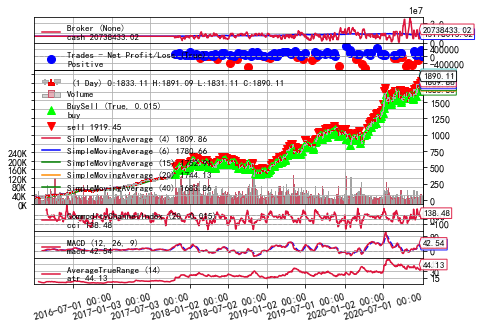

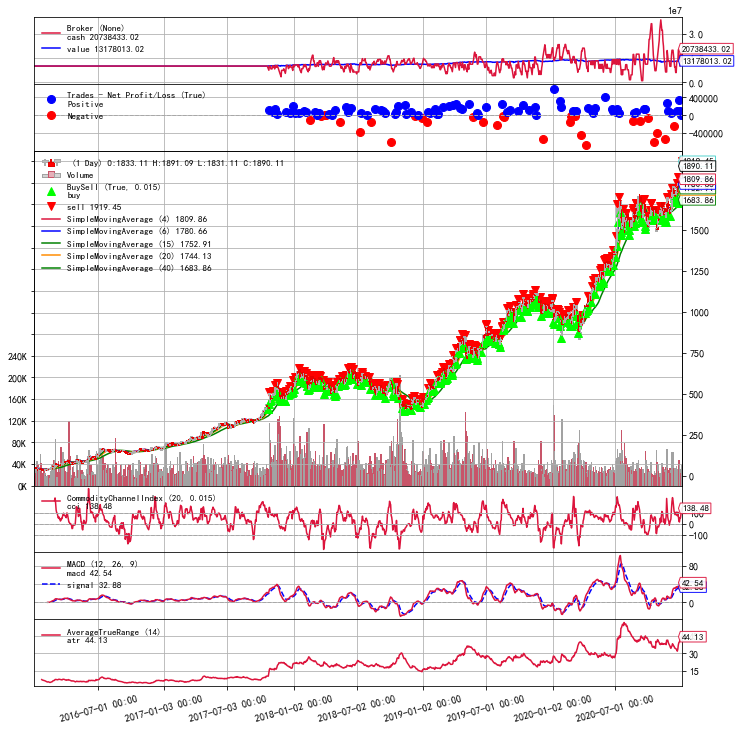

In [3]:
%matplotlib inline
fig = cerebro.plot(style='candlestick')
show = fig[0][0]
show.set_size_inches(10,10)#调整大小
show

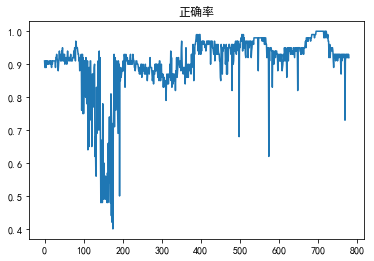

In [5]:
plt.plot(accuracies)
plt.title('正确率')
plt.show()